## Test out UAV env

In [1]:
# Standard stuff to import
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *
from utils.train_test_methods import *
from utils.params import *
from utils.retrieve_sim import *

from importlib import reload
import utils

input_type = U_VELOCITY
observe_type = O_VELOCITY
observe_action = O_ACTION
reward_mode=ALL_REWARD

import os
try:
    os.mkdir('screencaps')
except:
    pass


In [2]:
# More standard stuff to import
reload(utils.ReplayMemory)
reload(utils.networks)
reload(utils.agents)
reload(utils.plotting)
reload(utils.train_test_methods)
from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *
from utils.train_test_methods import *

num_episode=2000#250#500
test_interval=40#0
num_test=4#50
num_iteration=1000
BATCH_SIZE=64#128
save_sim_intv=50
debug=False
num_sample=50
seed=22222
hidden=16
action_space=[-1,1]

# rand_mode = NO_RAND
rand_mode = GAUSS_RAND


In [3]:
# Create an instance of the UAV env
# reload(UAV_env)
from UAV_env import *
env = UAVEnv()
N = 1
# Create corresponding agent by providing it with necessary input/output sizes
agent = AC2Agent(device, 1, env.n_states, 
                 env.n_actions, hidden, rand_modeA=rand_mode, centralized=True,
                 learning_rateA=0.01, learning_rateC=0.02, mode=1208)

In [4]:
# Define customized training method.
# Obtaining next_state, observation, reward, etc. directly from env in this method. 
def train(agent, env, num_episode=50, test_interval=25, num_test=20, num_iteration=200, iteration_cutoff=0, 
          BATCH_SIZE=128, num_sample=50, action_space=[-1,1], debug=True, memory=None, seed=2020,
          update_mode=UPDATE_PER_ITERATION, reward_mode=FUTURE_REWARD_NO, gamma=0.99, 
          loss_history=[], loss_historyA=[], lr_history=[], lr_historyA=[], reward_mean_var=(0,-1),
          save_sim_intv=50, save_sim_fnames=[], imdir='screencaps/', useVid=False, save_intm_models=False,
          not_use_rand_in_action=False, not_use_rand_in_test=True, 
         return_memory=False, N=1):
    test_hists = []
    steps = 0
    if memory is None:
        memory = ReplayMemory(1000 * N)
    if iteration_cutoff <= 0:
        iteration_cutoff = num_iteration # Save all iterations into the memory
    
    # Note that the seed only controls the numpy random, which affects the environment.
    # To affect pytorch, refer to further documentations: https://github.com/pytorch/pytorch/issues/7068
    np.random.seed(seed)
    test_seeds = np.random.randint(0, 2112, size=int(num_episode // test_interval)+1)
    
    (rmean, rvar) = reward_mean_var

    for e in range(num_episode):
        steps = 0
        env.reset()
        state = env.state
        state = torch.from_numpy(state).float()
        state = Variable(state)
        
        state_pool = []
        action_pool = []
        reward_pool = []
        next_state_pool = []
        loss_history.append([])
        loss_historyA.append([])

        for t in range(num_iteration):
            agent.set_train(True)
            # Try to pick an action, react, and store the resulting behavior in the pool here
            if agent.centralized:
                action = agent.select_action(state, **{
                        'steps_done':t, 'num_sample':50, 'action_space':action_space, 'rand':not_use_rand_in_action
                    }).T
            else:
                pass

            if torch.is_tensor(action):
                next_state, reward, done, _ = env.step(action.detach().numpy())
            else:
                next_state, reward, done, _ = env.step(action)
                
            next_state = Variable(torch.from_numpy(next_state).float()) # The float() probably avoids bug in net.forward()
            action = action.T # Turn shape back to (N,2)

            if agent.needsExpert:
                # If we need to use expert input during training, then we consult it and get the best action for this state
                actions = env.controller()
                action = actions.T # Shape should already be (2,N), so we turn it into (N,2)
            
            if agent.centralized:
                reward = np.sum(reward)

            # Update 1028: Moved this training step outside the loop
            if update_mode == UPDATE_PER_ITERATION:
                if reward_mode & FUTURE_REWARD_YES == 0 and reward_mode & FUTURE_REWARD_NORMALIZE == 0:
                    if agent.centralized:
                        memory.push(state, action, next_state, reward, reward)
                    else:
                        pass
                # Learn
                if len(memory) >= BATCH_SIZE:
                    transitions = memory.sample(BATCH_SIZE)
                    batch = Transition(*zip(*transitions))
                    agent.optimize_model(batch, **{'B':BATCH_SIZE})
                elif len(memory) > 0:
                    transitions = memory.sample(len(memory))
                    batch = Transition(*zip(*transitions))
                    agent.optimize_model(batch, **{'B':len(memory)})
                loss_history[-1].append(agent.losses[:])
                agent.losses=[]
                try:
                    loss_historyA[-1].append(agent.lossesA[:])
                    agent.lossesA=[]
                except:
                    pass
            elif update_mode == UPDATE_ON_POLICY:
                # This case would ditch sampling, and just update by the current thing.
                # Note that methods that use future cumulative reward would be highly incompatible with this...
                if not(agent.centralized) or reward_mode & FUTURE_REWARD_YES != 0:
                    print("Error: Update-on-policy might be incompatible with decentralized planning or cumulative reward")
                    return None
                if rvar == -1 and rmean == 0 and reward_mode & FUTURE_REWARD_NORMALIZE != 0:
                    rvar = np.abs(reward)
                    rmean = reward
                reward = (reward - rmean) / rvar
                
                batch = Transition(state, action, next_state, [[reward]], [[reward]])
                agent.optimize_model(batch, **{'B':1})
                loss_history[-1].append(agent.losses[:])
                agent.losses=[]
                try:
                    loss_historyA[-1].append(agent.lossesA[:])
                    agent.lossesA=[]
                except:
                    pass
            else:
                # Store and push them outside the loop
                state_pool.append(state)
                if torch.is_tensor(action):
                    action_pool.append(action.detach().numpy())
                else:
                    action_pool.append(action)
                reward_pool.append(reward)
                next_state_pool.append(next_state)
            state = next_state
            steps += 1

            if debug and done:
                print("Took ", t, " steps to converge")
                break
        
        # Now outside the iteration loop - prepare for per-episode trainings
        if update_mode == UPDATE_ON_POLICY:
            pass
        elif update_mode == UPDATE_PER_EPISODE: 
            inst_reward = torch.tensor(reward_pool)
            if reward_mode & FUTURE_REWARD_YES != 0:
                for j in range(len(reward_pool)): ### IT was previously miswritten as "reward". Retard bug that might had effects
                    if j > 0:
                        reward_pool[-j-1] += gamma * reward_pool[-j]
            reward_pool = torch.tensor(reward_pool)
            if reward_mode & FUTURE_REWARD_NORMALIZE != 0:
                if rvar == -1 and rmean == 0:
                    rmean = reward_pool.mean()
                    rvar = reward_pool.std()
                    print("Updated mean and stdev: {0} and {1}".format(rmean.numpy(), rvar.numpy()))
                reward_pool = (reward_pool - rmean) / rvar
                inst_reward = (inst_reward - rmean) / rvar

            if agent.centralized:
                for j in range(iteration_cutoff):
                    memory.push(state_pool[j], action_pool[j], 
                                next_state_pool[j], reward_pool[j], inst_reward[j])
            else:
                pass
            
        if update_mode == UPDATE_PER_EPISODE:
            if len(memory) >= BATCH_SIZE:
                transitions = memory.sample(BATCH_SIZE)
                batch = Transition(*zip(*transitions))
                agent.optimize_model(batch, **{'B':BATCH_SIZE})
            elif len(memory) > 0:
                transitions = memory.sample(len(memory))
                batch = Transition(*zip(*transitions))
                agent.optimize_model(batch, **{'B':len(memory)})
            loss_history[-1].append(agent.losses[:])
            agent.losses=[]
            try:
                loss_historyA[-1].append(agent.lossesA[:])
                agent.lossesA=[]
            except:
                pass
        
        if debug:
            print("Episode ", e, " finished; t = ", t)
        
        if e % test_interval == 0:
            print("Test result at episode ", e, ": ")
            test_hist = test(agent, env, num_test, num_iteration, num_sample, action_space, 
                             seed=test_seeds[int(e/test_interval)], debug=debug, not_use_rand_in_action=not_use_rand_in_test)
            test_hists.append(test_hist)
        
        # Save demos of simulation if wanted
        if e % save_sim_intv == (save_sim_intv-1) and e > 0:
            try:
                fnames = [f+'_{0}'.format(e) for f in save_sim_fnames]
                plot_test(agent, env, fnames=fnames,
                    num_iteration=num_iteration, action_space=action_space, imdir=imdir,
                    debug=debug, useVid=useVid, not_use_rand=not_use_rand_in_test)
                for f in fnames:
                    os.system('ffmpeg -y -pattern_type glob -i "'+imdir+f+'*.jpg" '+f+'.gif')
            except:
                print("Failed to save simulation at e={0}".format(e))
            if save_intm_models and len(save_sim_fnames) > 0:
                agent.save_model(save_sim_fnames[0]+'_{0}'.format(e))
    if return_memory:
        return test_hists, memory
    else:
        return test_hists
                
def test(agent, env, num_test=20, num_iteration=200, num_sample=50, action_space=[-1,1], seed=2020, debug=True, 
        not_use_rand_in_action=False, N=1):
    reward_hist_hst = []
    np.random.seed(seed)
    env_seeds = np.random.randint(0, 1984, size=num_test)
    with torch.no_grad(): 
        for e in range(num_test):
            steps = 0
            agent.set_train(False)
            cum_reward = 0
            reward_hist = []

            np.random.seed(env_seeds[e])
            state = env.reset()
            if agent.centralized:
                state = env.state
            state = torch.from_numpy(state).float()
            state = Variable(state)
            if debug:
                env.render()

            for t in range(num_iteration):  
                # Try to pick an action, react, and store the resulting behavior in the pool here.
                # If not_use_rand_in_action is set to True, then presumably the agents would take the middle of
                # its action range as the action it takes.
                if agent.centralized:
                    action = agent.select_action(state, **{
                            'steps_done':t, 'rand':not_use_rand_in_action, 'num_sample':50, 'action_space':action_space
                        }).T
                else:
                    pass

                if torch.is_tensor(action):
                    next_state, reward, done, _ = env.step(action.detach().numpy())
                else:
                    next_state, reward, done, _ = env.step(action)
                if agent.centralized:
                    next_state = env.state
                next_state = Variable(torch.from_numpy(next_state).float()) # The float() probably avoids bug in net.forward()
                state = next_state
                try:
                    cum_reward += sum(reward)
                except:
                    cum_reward += reward
                reward_hist.append(reward)

                steps += 1

                if done:
                    break
            if debug:
                print("Finished test ", e, " with ", t, #" steps, and rewards = ", reward, 
                  "; cumulative reward = ", cum_reward)
            reward_hist_hst.append(reward_hist)
        env.close()
        return reward_hist_hst

In [5]:
sim_fnames = ['UAV_']
lost_hist = [[]]
hist = train(agent, env, 
              num_episode=num_episode, test_interval=test_interval, num_test=num_test, num_iteration=num_iteration, 
              BATCH_SIZE=BATCH_SIZE, num_sample=num_sample, action_space=[-1,1], debug=debug, 
#               update_mode=UPDATE_PER_ITERATION, reward_mode=FUTURE_REWARD_YES_NORMALIZE, 
              update_mode=UPDATE_PER_EPISODE, 
              reward_mode=FUTURE_REWARD_NORMALIZE|FUTURE_REWARD_YES,
              loss_history=lost_hist[0],
              save_sim_intv=save_sim_intv, save_sim_fnames=sim_fnames, 
              imdir='screencaps/', useVid=False)

Updated mean and stdev: -51.903241671028226 and 12.537275210639097
Test result at episode  0 : 
Test result at episode  40 : 
Failed to save simulation at e=49
Test result at episode  80 : 
Failed to save simulation at e=99
Test result at episode  120 : 
Failed to save simulation at e=149
Test result at episode  160 : 
Failed to save simulation at e=199
Test result at episode  200 : 
Test result at episode  240 : 
Failed to save simulation at e=249
Test result at episode  280 : 
Failed to save simulation at e=299
Test result at episode  320 : 
Failed to save simulation at e=349
Test result at episode  360 : 
Failed to save simulation at e=399
Test result at episode  400 : 
Test result at episode  440 : 
Failed to save simulation at e=449
Test result at episode  480 : 
Failed to save simulation at e=499
Test result at episode  520 : 
Failed to save simulation at e=549
Test result at episode  560 : 
Failed to save simulation at e=599
Test result at episode  600 : 
Test result at episode 

IndexError: list index out of range

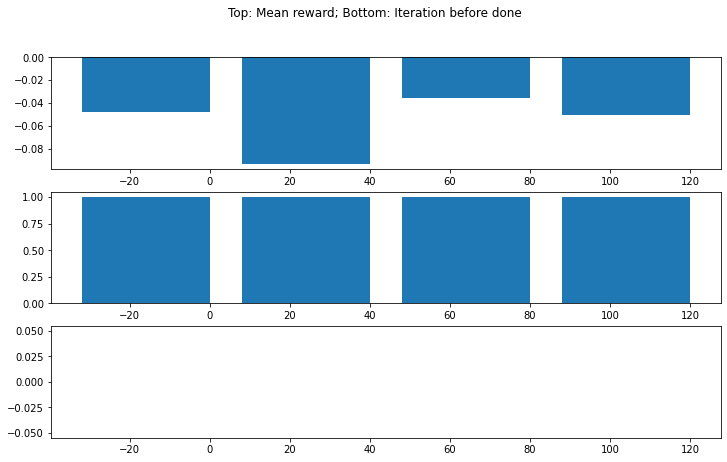

In [6]:
# Plot performance history
skip=1
plot_reward_hist([h[::skip] for h in hist], test_interval*skip, 
                 ['UAV'], 
                 log=False, num_iteration=num_iteration, N_list=[1], bar=True)

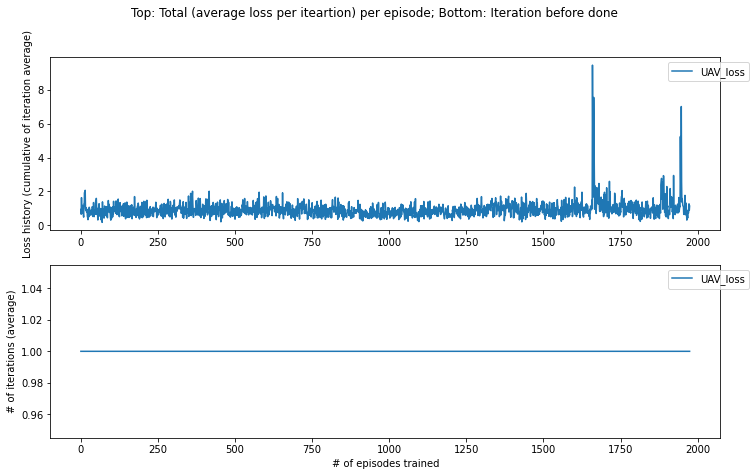

In [8]:
# Plot loss history
skip=1
plot_loss_hist(hists=[h[25::skip] for h in lost_hist], 
               hist_names=['UAV_loss'], log=False, 
               num_iteration=num_iteration, update_mode=UPDATE_PER_ITERATION, bar=False)